In [1]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


### Tail Tip & Head Tip Co-ordinate Data input

In [2]:
from csv import reader
from Tkinter import Tk
from tkFileDialog import askopenfilename

#init the rawdata container
rawdata = []

#open GUI file chooser dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print 'Loading from %s' % filename
with open(filename) as f:
    rows = reader(f, delimiter=',')
    for ax,ay,px,py in rows:
        rawdata.append((ax,ay,px,py))

#Drop the header line
rawdata = rawdata[1:]
print 'Loaded %i rows of raw data.' % len(rawdata)

#Transpose
AX,AY,PX,PY = zip(*rawdata)
from numpy import array
AX = array(AX, dtype=float)
AY = array(AY, dtype=float)
PX = array(PX, dtype=float)
PY = array(PY, dtype=float)
print 'datatypes', [AX.dtype, AY.dtype, PX.dtype, PY.dtype]

Loading from /Volumes/My Passport/SKF_100_rep/Images&tracked/Tracked/C1_F1tailextremes.csv
Loaded 5279 rows of raw data.
datatypes [dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


### Raw Tail Tip Trajectory (w.r.t. Y axis)

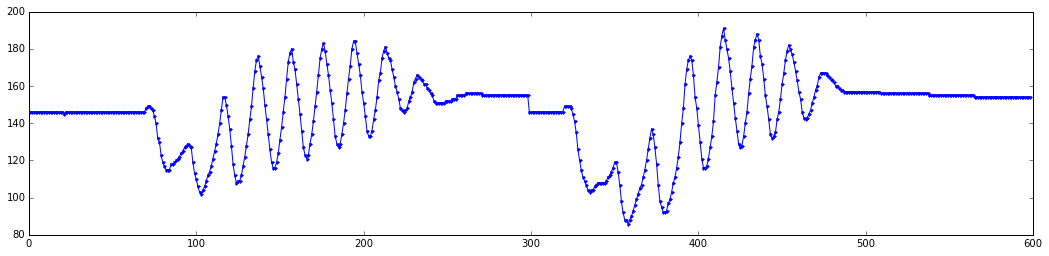

In [10]:
    from matplotlib import pyplot as plt
    plt.figure(figsize=(18,4))
    plt.plot(PY,'.-')
    plt.show()


### Thresholding to find true events

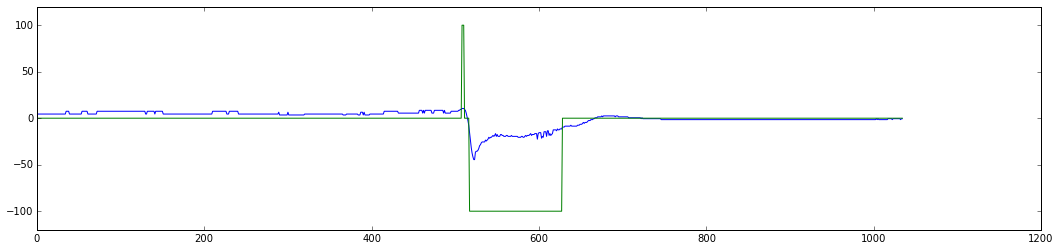

In [27]:
plt.figure(figsize=(18,4))

from numpy import ones

#Zero mean
zeroPY = PY - ones(len(PY), dtype=PY.dtype)*PY.mean()
plt.plot(zeroPY)


'''
    Tail Displacement Threshold in pixels : "threshold"
    'IF abs(PY) > threshold THEN tail has moved'
'''
#=================================
threshold =10
#=================================

factor =  threshold*10
thresholdedPY = zeroPY.copy()
#   Mid range
thresholdedPY[(-threshold < thresholdedPY) & (thresholdedPY < threshold)] = 0
#   Minima
thresholdedPY[thresholdedPY <= -threshold] = -1
#   Maxima
thresholdedPY[thresholdedPY >= threshold] = 1

plt.ylim(-factor*1.2,factor*1.2)
plt.plot([v*factor for v in thresholdedPY])

Bout Detection
--------------

Significant bouts indices [[508, 628]]


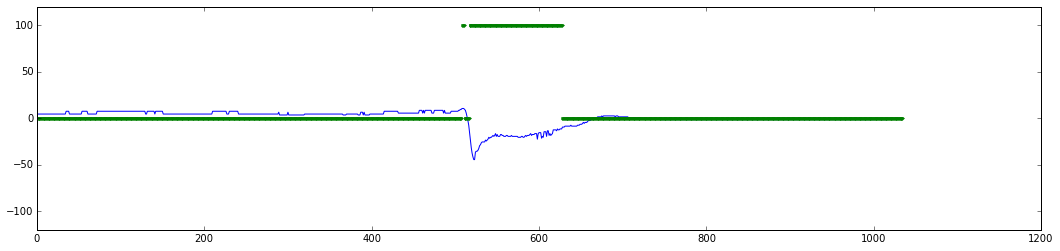

In [28]:
plt.figure(figsize=(18,4))

absPY = abs(thresholdedPY.copy())

plt.plot(zeroPY)
plt.plot([v*factor for v in absPY], '.')
plt.ylim(-factor*1.2,factor*1.2)


#Convert to string
absPY = absPY.astype(int)
seqstr = ''.join(str(v) for v in absPY)



#'1-fill' the 'gaps'
maxgap = 5   #frames

for k in range(1,maxgap+1):
    oldp = '1' + '0'*k +'1'
    newp = '1' + '1'*k +'1'
    seqstr = seqstr.replace(oldp,newp)
#print seqstr



'''
    Bout interval : "boutinterval"
    'IF two [1]+ sequences are separated by greater than boutinterval frames
        THEN they constitute two separate bouts'
'''
boutinterval =20#frames

import re
rx = re.compile('1+')
#Indices
bouts_i = [list(ib.span()) for ib in rx.finditer(seqstr)]
#print bouts_i
#print len(bouts_i)
#Distances
bouts_d = [0] + [bouts_i[k][0] - bouts_i[k-1][1] for k in range(1,len(bouts_i))]
bouts = [bouts_i[0]]
for k in range(1,len(bouts_d)):
    if bouts_d[k] > boutinterval:
        bouts.append(bouts_i[k])
    else:
        bouts[-1][1] = bouts_i[k][1]

#print bouts
#print len(bouts)

bouts_l = [k-j for j,k in bouts]
#print bouts_l


'''
Min bout duration : min_bout_dur in frames
'''
min_bout_dur = 20#frames

bouts = [bouts[k] for k in range(len(bouts)) if bouts_l[k] > min_bout_dur]
print 'Significant bouts indices', bouts


#### 1. Bout Count

In [29]:
print '%i bouts detected' % len(bouts)


1 bouts detected


#### 2. Isolated bouts

[[508, 628]]


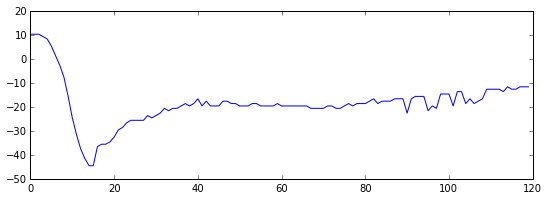

In [30]:
plt.figure(figsize=(9,3))
k = 3
for k in range(len(bouts)):
    bout = bouts[k]
    plt.plot(zeroPY[range(bout[0],bout[1])])
print bouts

#### 3. Bout Durations [frames]

[120]


<Container object of 1 artists>

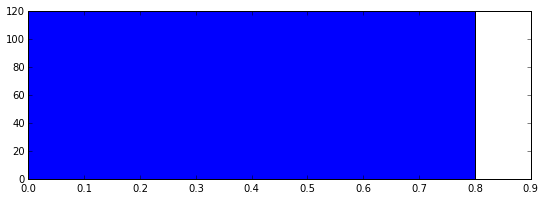

In [31]:
durs = [k-j for j,k in bouts]
print durs
plt.figure(figsize=(9,3))
plt.bar(range(len(durs)),durs)

## 4. Bout Max Amplitudes [px]

[55.0]


<Container object of 1 artists>

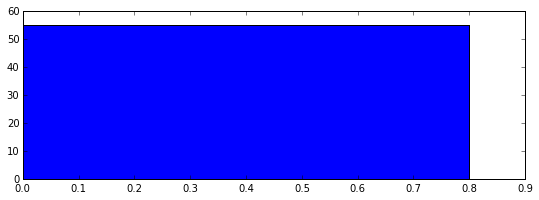

In [32]:
max_amplitudes = []
for start,end in bouts:
    data = zeroPY[start:end]
    v = max(data) - min(data)
    max_amplitudes.append(v)
print max_amplitudes
plt.figure(figsize=(9,3))
plt.bar(range(len(max_amplitudes)),max_amplitudes)

#### 5. Bout Max Frequency [Hz]

Max 4.80769230769 Hz


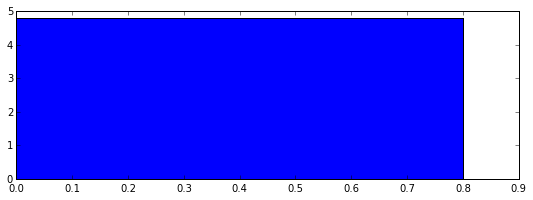

In [201]:
fps = 500
spf = 1.0/fps

max_freqs = []
for start,end in bouts:
    data = zeroPY[start:end]
    v = 1.0/(spf*abs(data.argmax() - data.argmin()))
    max_freqs.append(v)

plt.figure(figsize=(9,3))
plt.bar(range(len(max_freqs)),max_freqs)

print 'Max', mean(max_freqs), 'Hz'

##### 5a. Bout with highest frequency of tail flick 

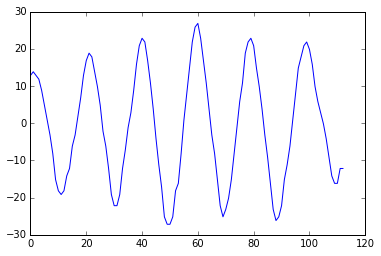

In [12]:
bout = bouts[1]
plt.plot(zeroPY[range(bout[0],bout[1])])

##### 5b. Bout with lowest frequency of tail flick 

In [13]:
bout = bouts[3]
plt.plot(zeroPY[range(bout[0],bout[1])])

IndexError: list index out of range

#### 6. Head to Tail angle

Median: 0.0 SEM: 8.84775968867


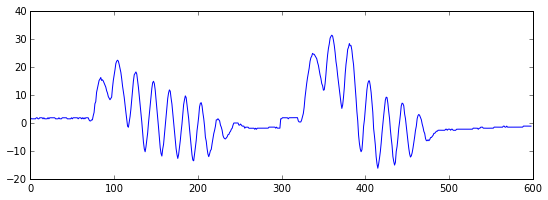

In [11]:
import numpy as np
is_bigger_than_theshold = list()
from math import atan2, degrees
degrees(atan2(2.0,1.0))

angles_head_tail = [degrees(atan2(ay-py, ax-px)) for ax,ay,px,py in zip(AX,AY,PX,PY)]
print 'Median:', median(angles_head_tail), 'SEM:', std(angles_head_tail)
is_bigger_than_threshold = [i for i in angles_head_tail for ax,ay,px,py in zip (AX,AY,PX,PY)if i >= 20]
#plt.plot (is_bigger_than_threshold)

plt.figure(figsize=(9,3))
plt.plot(angles_head_tail)





## 7. Tail flick frequency by FFT <br> ref: http://stackoverflow.com/questions/15382076/plotting-power-spectrum-in-python

Max 25.3718285214 Hz


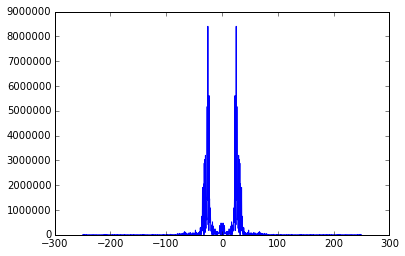

In [156]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

#data = np.random.rand(301) - 0.5
#bout = bouts[6]
#data = array(zeroPY[range(bout[0],bout[1])])
data = array(zeroPY)

ps = np.abs(np.fft.fft(data))**2

time_step = 1 / 500
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])


vals = [(f*p,f) for f,p in zip(freqs[idx], ps[idx])]
print 'Max', max(vals, key=lambda ele: ele[0])[1], 'Hz'


### Spline data input

#### Raw data

In [3]:
from Tkinter import Tk

#init the rawdata container
rawdata = []

#number of segments in each spline
nsegs = 0

#open GUI file chooser dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print 'Loading from %s' % filename
with open(filename) as f:
    rows = reader(f, delimiter=',')
    #Spline segments count
    row = next(rows)
    nsegs = len(row)/2 - 1
    print 'Detected %i segment spline data' % nsegs

    #Load all rows
    rawdata.append(map(float, row))
    for row in rows:
        rawdata.append(map(float, row))

print 'Loaded %i rows of raw data.' % len(rawdata)



Loading from /Users/urvashijha/Desktop/DATA/splines.csv
Detected 8 segment spline data
Loaded 3537 rows of raw data.


#### Vectorised data

In [6]:
from numpy import array

arrdata = array(rawdata)
rows, cols = arrdata.shape
print 'Raw Data Array shape:', (rows, cols)

print 'Constructing vectors...'

ppvs = point_position_vectors = [arrdata[:rows, k:k+2] for k in range(0,cols,2)]
print len(ppvs), 'point-position-vectors per %i-segment spline' % nsegs
svs = segment_vectors = [ppvs[k]-ppvs[k+1] for k in range(len(ppvs)-1)]
print len(svs), 'segment vectors per %i-segment spline' % nsegs


Raw Data Array shape: (3537, 18)
Constructing vectors...
9 point-position-vectors per 8-segment spline
8 segment vectors per 8-segment spline


#### 1. Inter-segment angles

In [12]:
# v1 = svs[0]
# v2 = svs[1]

# v1 = v1 / 

# print arccos(dot(v1[0], v2[0]))
# a
# # print svs[0].shape, svs[1].shape
# # angles = arccos(diag(dot(svs[0], svs[1].T)))

# # angles = [arccos(v[k].dot(vk+1)) for k in range(len(svs))]
import numpy as np
from matplotlib import pyplot as plt

print 'Plotting %i inter-segment angles w.r.t. t' % (len(svs) - 1)
print 'Anterior --> Posterior :: Low value --> High value'
print 'Raw data Y-co-ordinate trace stacked at the very top'
 
for k in range(len(svs)-1):
    v1 = svs[k]
    v2 = svs[k+1]
    #Normalize
    v1 = np.divide(v1.T , np.sqrt(np.sum(np.power(v1, 2), axis=1)) ).T
    v2 = np.divide(v2.T , np.sqrt(np.sum(np.power(v2, 2), axis=1)) ).T
    angles = np.degrees(np.arccos(np.diag(np.dot(v1, v2.T))))
    plt.plot(angles + k*50)
    plt.plot(zeroPY + 400)
    del v1
    del v2

plt.show()

Plotting 7 inter-segment angles w.r.t. t
Anterior --> Posterior :: Low value --> High value
Raw data Y-co-ordinate trace stacked at the very top


/Users/urvashijha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: RuntimeWarning: invalid value encountered in arccos


In [12]:
#peak detextion for turns
!pip install PeakUtils


You are using pip version 7.0.3, however version 8.1.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
#peakdeteaction for turns
import numpy
import peakutils
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline


[176 415]


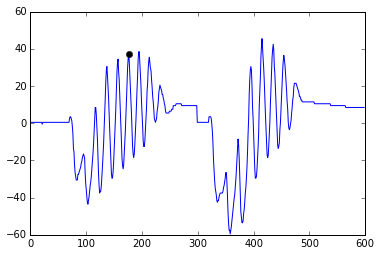

In [18]:
#Amplitude for turns 
zeroPY = PY - ones(len(PY), dtype=PY.dtype)*PY.mean()
plt.plot(zeroPY)
indexes_amplitude_turn = peakutils.indexes(zeroPY, thres=0, min_dist=100)
print(indexes_amplitude_turn)
#print "zeroPY[523]: ", zeroPY[523]
#plot(176,zeroPY[176],'-ko')











<type 'list'>
[415]
<type 'numpy.ndarray'>
angles_head_tail[415]:  16.21338169


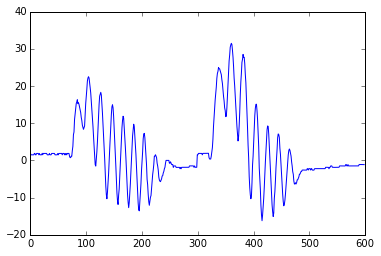

In [20]:
#Tailbendangle for Turns
import numpy as np
from math import atan2, degrees
degrees(atan2(2.0,1.0))
neg_angles_head_tail = [degrees(atan2(ay-py, ax-px)) for ax,ay,px,py in zip(AX,AY,PX,PY)]
plt.plot(neg_angles_head_tail)
print(type(neg_angles_head_tail))
angles_head_tail = [-x for x in neg_angles_head_tail]
angles_head_tail = np.asarray(angles_head_tail)
#angles_head_tail= [int(n) for n in list_angles_head_tail]
indexes_amplitude_turn = peakutils.indexes(angles_head_tail, thres=-10, min_dist=2000)
print(indexes_amplitude_turn)
print(type(angles_head_tail))
print "angles_head_tail[415]: ", angles_head_tail[415]


